# Import Packages

In [16]:
import os
import pickle as pkl
import sys
import numpy as np
import pandas as pd
import sklearn
import csv
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
import seaborn as sns
import ot
import plotly.graph_objs as go
import plotly.express as px
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

# Define variables (used across the code)

In [2]:
# Define unique colors
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)

### configuration
n_eps = 15 # number of epsilon values tried
eps_range = [0.04, 5] # the range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps) # epsilon values

# Define Utility Functions

In [19]:
def add_colored_label(ax, x, y, bgcolor, width=1, height=1):
  rect = Rectangle((x, y), width, height, facecolor=bgcolor)
  ax.add_patch(rect)

def show_heatmaps(vmin_val, vmax_val, matrices, titles, cbar_label=None, color_labels=None):
    num_plots = len(matrices)
    grid_size = math.ceil(math.sqrt(num_plots))  # Determine the grid size
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(5 * grid_size, 5 * grid_size))

    # Flatten the axes array if it is 2D
    if isinstance(axs, np.ndarray):
        axs = axs.ravel()
    else:
        axs = [axs]

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axs[i]
        
        im = ax.imshow(matrix, aspect='auto', vmin=vmin_val, vmax=vmax_val)
        ax.set_title(title)

        # Set axis labels
        ax.set_xlabel("Right")  # Label for x-axis
        ax.set_ylabel("Left")   # Label for y-axis

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label(cbar_label)

        # Adjust the height of the color bar
        position = cax.get_position()
        new_position = [position.x0, position.y0 + 0.1, position.width, position.height * 0.8]
        cax.set_position(new_position)

        if color_labels is not None:
            ax.axis('off')
            for idx, color in enumerate(color_labels):
                add_colored_label(ax, -1.5, idx - 0.5, color, width=0.8)
                add_colored_label(ax, idx - 0.5, matrix.shape[1] - 0.2, color, height=0.8)

            ax.set_aspect('equal')
            ax.set_xlim(-3.0, matrix.shape[1])
            ax.set_ylim(-1, len(color_labels) + 1.4)
            ax.invert_yaxis()

            for spine in ax.spines.values():
                spine.set_visible(False)

    # Hide unused axes
    for ax in axs[num_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
"""
def show_heatmaps(vmin_val, vmax_val, matrices, titles, cbar_label=None, color_labels=None):
    num_plots = len(matrices)
    # fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5)) # all plots in one row
    fig, axs = plt.subplots(math.ceil(math.sqrt(num_plots)), math.ceil(math.sqrt(num_plots)), figsize=(5*num_plots, 5))

    if num_plots == 1:
        axs = [axs]

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axs[i]
        
        im = ax.imshow(matrix, aspect='auto', vmin=vmin_val, vmax=vmax_val)
        ax.set_title(title)

        # Set axis labels
        ax.set_xlabel("Right")  # Label for x-axis
        ax.set_ylabel("Left")   # Label for y-axis

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label(cbar_label)

        # Adjust the height of the color bar
        position = cax.get_position()
        new_position = [position.x0, position.y0 + 0.1, position.width, position.height * 0.8]
        cax.set_position(new_position)

        if color_labels is not None:
            ax.axis('off')
            for idx, color in enumerate(color_labels):
                add_colored_label(ax, -1.5, idx-0.5, color, width=0.8)
                add_colored_label(ax, idx-0.5, matrix.shape[1] - 0.2, color, height=0.8)

            ax.set_aspect('equal')
            ax.set_xlim(-3.0, matrix.shape[1])
            ax.set_ylim(-1, len(color_labels)+1.4)
            ax.invert_yaxis()

            for spine in ax.spines.values():
                spine.set_visible(False)

    plt.tight_layout()
    plt.show()
"""
def show_heatmap(matrix, title, cbar_label=None, color_labels=None):
    fig, ax = plt.subplots(figsize=(5, 5))

    im = ax.imshow(matrix, aspect='auto', vmin=0, vmax=7)
    ax.set_title(title)

    # Set axis labels
    ax.set_xlabel("Right")  # Label for x-axis
    ax.set_ylabel("Left")   # Label for y-axis

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(cbar_label)

    # Adjust the height of the color bar
    position = cax.get_position()
    new_position = [position.x0, position.y0 + 0.1, position.width, position.height * 0.8]
    cax.set_position(new_position)

    if color_labels is not None:
        ax.axis('off')
        for idx, color in enumerate(color_labels):
            add_colored_label(ax, -1.5, idx - 0.5, color, width=0.8)
            add_colored_label(ax, idx - 0.5, matrix.shape[1] - 0.2, color, height=0.8)

        ax.set_aspect('equal')
        ax.set_xlim(-3.0, matrix.shape[1])
        ax.set_ylim(-1, len(color_labels) + 1.4)
        ax.invert_yaxis()

        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.show()


def transform_value(value):
    return -value + 3.5

def RSA(matrix1, matrix2, method='pearson'):
  upper_tri_1 = matrix1[np.triu_indices(matrix1.shape[0], k=1)]
  upper_tri_2 = matrix2[np.triu_indices(matrix2.shape[0], k=1)]
  if method == 'pearson':
    corr, _ = pearsonr(upper_tri_1, upper_tri_2)
  elif method == 'spearman':
    corr, _ = spearmanr(upper_tri_1, upper_tri_2)

  return corr

def comp_matching_rate(OT_plan, k, order="maximum"):
  # This function computes the matching rate, assuming that in the optimal transportation plan,
  # the items in the i-th row and the j-th column are the same (correct mactch) when i = j.
  # Thus, the diagonal elements of the optimal transportation plan represent the probabilities
  # that the same items (colors) match between the two structures.

  # Get the diagonal elements
  diagonal = np.diag(OT_plan)
  # Get the top k values for each row
  if order == "maximum":
      topk_values = np.partition(OT_plan, -k)[:, -k:]
  elif order == "minimum":
      topk_values = np.partition(OT_plan, k - 1)[:, :k]
  # Count the number of rows where the diagonal is in the top k values and compute the matching rate
  count = np.sum([diagonal[i] in topk_values[i] for i in range(OT_plan.shape[0])])
  matching_rate = count / OT_plan.shape[0] * 100
  return matching_rate

# Function to plot the embeddings
## Not used in this code
def plot_embeddings(embeddings, titles, color_labels, overlay=False):
    fig = go.Figure()
    
    if overlay:
        for i, embedding in enumerate(embeddings):
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center",
                name=titles[i]
            ))
    else:
        for i, embedding in enumerate(embeddings):
            fig = go.Figure()
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center"
            ))
            fig.update_layout(
                title=f'MDS Embedding - {titles[i]}',
                scene=dict(
                    xaxis_title='Dimension 1',
                    yaxis_title='Dimension 2',
                    zaxis_title='Dimension 3'
                ),
                height=800
            )
    fig.show()

# Define the function to compute minimum GWD for the range of epsilons
def compute_min_gwd(matrix_1, matrix_2, epsilons):

    OT_plans = []
    gwds = []
    matching_rates = []

    for epsilon in epsilons:
      OT, gw_log = ot.gromov.entropic_gromov_wasserstein(C1=matrix_1, C2=matrix_2 , epsilon=epsilon, loss_fun="square_loss", log=True)  # optimization
      gwd = gw_log['gw_dist']
      matching_rate = comp_matching_rate(OT, k=1)  # calculate the top 1 matching rate
      OT_plans.append(OT)
      gwds.append(gwd)
      matching_rates.append(matching_rate)

    return min(gwds)

def GWD_and_plot(matrix1, matrix2, epsilons):
    
    OT_plans = []
    gwds = []
    matching_rates = []

    for epsilon in epsilons:
      OT, gw_log = ot.gromov.entropic_gromov_wasserstein(C1=matrix1, C2=matrix2 , epsilon=epsilon, loss_fun="square_loss", log=True)  # optimization
      gwd = gw_log['gw_dist']
      matching_rate = comp_matching_rate(OT, k=1)  # calculate the top 1 matching rate
      OT_plans.append(OT)
      gwds.append(gwd)
      matching_rates.append(matching_rate)

      
    plt.scatter(epsilons, gwds, c=matching_rates)
    plt.xlabel("epsilon")
    plt.ylabel("GWD")
    plt.xscale('log')
    plt.grid(True, which = 'both')
    cbar = plt.colorbar()
    cbar.set_label(label='Matching Rate (%)')
    plt.show()

    # extract the best epsilon that minimizes the GWD
    min_gwd = min(gwds)
    best_eps_idx = gwds.index(min_gwd)
    best_eps = epsilons[best_eps_idx]
    OT_plan = OT_plans[best_eps_idx]
    matching_rate = matching_rates[best_eps_idx]

    show_heatmaps(0, 0.1, matrices=[OT_plan], titles=[f'Optimal transportation plan \n GWD={min_gwd:.3f} \n matching rate : {matching_rate:.1f}%'])

    return OT_plan, gwds, matching_rates


def OT_epsilon(epsilons, OT_plans, gwds, e_ind, matching_rates):

    best_eps_idx = e_ind
    min_gwd = gwds[best_eps_idx]
    best_eps = epsilons[best_eps_idx]
    OT_plan = OT_plans[best_eps_idx]
    matching_rate = matching_rates[best_eps_idx]

    show_heatmaps(0, 0.05,
        matrices=[OT_plan],
        titles=[f'Optimal transportation plan \n GWD={min_gwd:.3f} \n matching rate : {matching_rate:.1f}%'],
        color_labels=unique_colours)
    
# Function to shuffle the upper and lower triangular parts of a matrix
def shuffle_upper_and_lower_triangular(matrix, size):
    # Create a copy of the matrix
    matrix_copy = matrix.copy()
    
    # Set the diagonal elements to zero
    np.fill_diagonal(matrix_copy, 0)

    # Shuffle the upper triangular elements
    upper_tri_indices = np.triu_indices(size, 1)
    upper_tri_values = matrix_copy[upper_tri_indices].copy()
    np.random.shuffle(upper_tri_values)
    matrix_copy[upper_tri_indices] = upper_tri_values
    
    # Shuffle the lower triangular elements
    lower_tri_indices = np.tril_indices(size, -1)
    lower_tri_values = matrix_copy[lower_tri_indices].copy()
    np.random.shuffle(lower_tri_values)
    matrix_copy[lower_tri_indices] = lower_tri_values
    
    # Return the shuffled matrix
    return matrix_copy

# Shuffle elements across rows except the diagonal elements
def shuffle_column_and_asymmetritisize(matrix, size):
    matrix_copy = matrix.copy()
    np.fill_diagonal(matrix_copy, 0)

    # Set the lower triangular part of the matrix to the negative of the upper triangular part
    for i in range(size):
        for j in range(i + 1, size):
            matrix_copy[j, i] = -matrix_copy[i, j]

    for i in range(size):
        non_diag_indices = [j for j in range(matrix_size) if j != i]
        non_diag_values = matrix_copy[non_diag_indices, i].copy()
        np.random.shuffle(non_diag_values)
        matrix_copy[non_diag_indices, i] = non_diag_values
    
    return matrix_copy

# Function to shuffle elements across rows except for the diagonal elements
def shuffle_row_and_asymmetritisize(matrix, size):
    matrix_copy = matrix.copy()
    
    # Set the diagonal elements to zero
    np.fill_diagonal(matrix_copy, 0)

    # Shuffle each row except for the diagonal elements
    for i in range(size):
        non_diag_indices = [j for j in range(size) if j != i]
        non_diag_values = matrix_copy[i, non_diag_indices].copy()
        np.random.shuffle(non_diag_values)
        matrix_copy[i, non_diag_indices] = non_diag_values
    for i in range(size):
        for j in range(i + 1, size):
            matrix_copy[j, i] = -matrix_copy[i, j]

    return matrix_copy

# Load Data

In [4]:
# Create matrix
matrix_1 = np.zeros((matrix_size, matrix_size))
matrix_2 = np.zeros((matrix_size, matrix_size))

# Load the second CSV file
df_PM1 = pd.read_csv('raw_data/kana_colourpreferencequalia-master/data/5a9b20c535237b0001129820_kana_colourPreferenceQualia_2024-11-14_03h40.27.980.csv')

# Filter for rows where 'response_type' is 'similarity'
df_PM1_similarity = df_PM1[df_PM1['response_type'] == 'similarity']

# Extract columns
colour1_1 = df_PM1_similarity['colour1']
colour2_1 = df_PM1_similarity['colour2']
target_preference_1 = df_PM1_similarity['response']

# Fill the matrix
for c1, c2, tp in zip(colour1_1, colour2_1, target_preference_1):
    I = colour_index[c1]
    j = colour_index[c2]
    matrix_1[j, I] = tp

# Load the second CSV file
df_PM2 = pd.read_csv('raw_data/kana_colourpreferencequalia-master/data/5eb05d66438b180fe44f6929_kana_colourPreferenceQualia_2024-11-13_22h37.20.028.csv')

# Filter for rows where 'response_type' is 'similarity'
df_PM2_similarity = df_PM2[df_PM2['response_type'] == 'similarity']

# Extract columns
colour1_2 = df_PM2_similarity['colour1']
colour2_2 = df_PM2_similarity['colour2']
target_preference_2 = df_PM2_similarity['response']

# Fill the matrix
for c1, c2, tp in zip(colour1_2, colour2_2, target_preference_2):
    I = colour_index[c1]
    j = colour_index[c2]
    matrix_2[j, I] = tp


# Raw Data - asymmetric

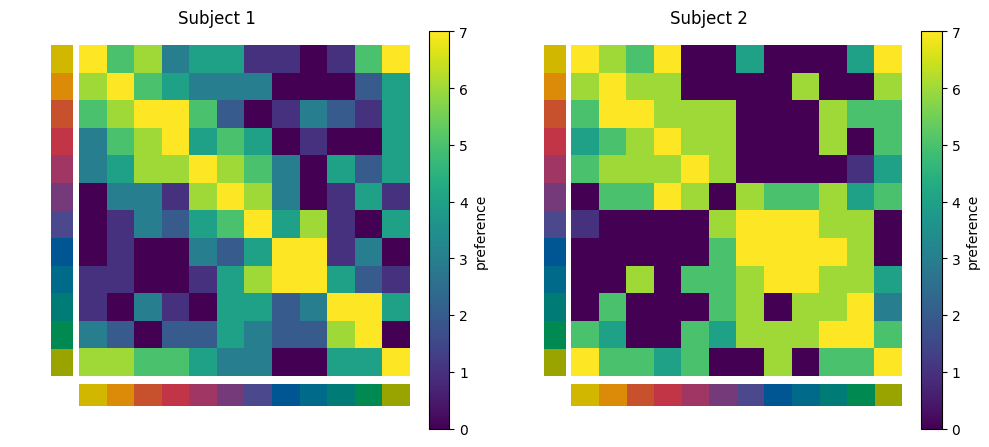

In [7]:
show_heatmaps(0, 7, matrices=[matrix_1, matrix_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

## Raw Data - List of all subject data

In [10]:
# Load datafiles for each participant and extract similarity matrices

pFiles = [] # stores source datafile for each participant, pFiles[pID] gives the file for participant pID
pCounter = 0 

pMatrices = [] # stores data matrix for each participant

for filename in os.listdir('raw_data/kana_colourpreferencequalia-master/data'):
    if filename.endswith(".csv"):
        filepath = os.path.join('raw_data/kana_colourpreferencequalia-master/data', filename)

        # This is another participant
        pFiles.append(filename)
        pCounter = pCounter + 1
        
        # Load the CSV file
        df = pd.read_csv(filepath)

        # Filter for rows where 'response_type' is 'similarity'
        df_similarity = df[df['response_type'] == 'similarity']

        # Extract columns
        colour1 = df_similarity['colour1']
        colour2 = df_similarity['colour2']
        target_preference = df_similarity['response']

        # Create and fill the matrix
        # NOTE double pass trials will overwrite the first trials (is this what we want?)
        matrix_size = len(colour_index)
        matrix = np.zeros((matrix_size, matrix_size))
        for c1, c2, tp in zip(colour1, colour2, target_preference):
            I = colour_index[c1]
            j = colour_index[c2]
            matrix[j, I] = tp

        # Store the matrix
        pMatrices.append(matrix)

pIds = range(0, pCounter)

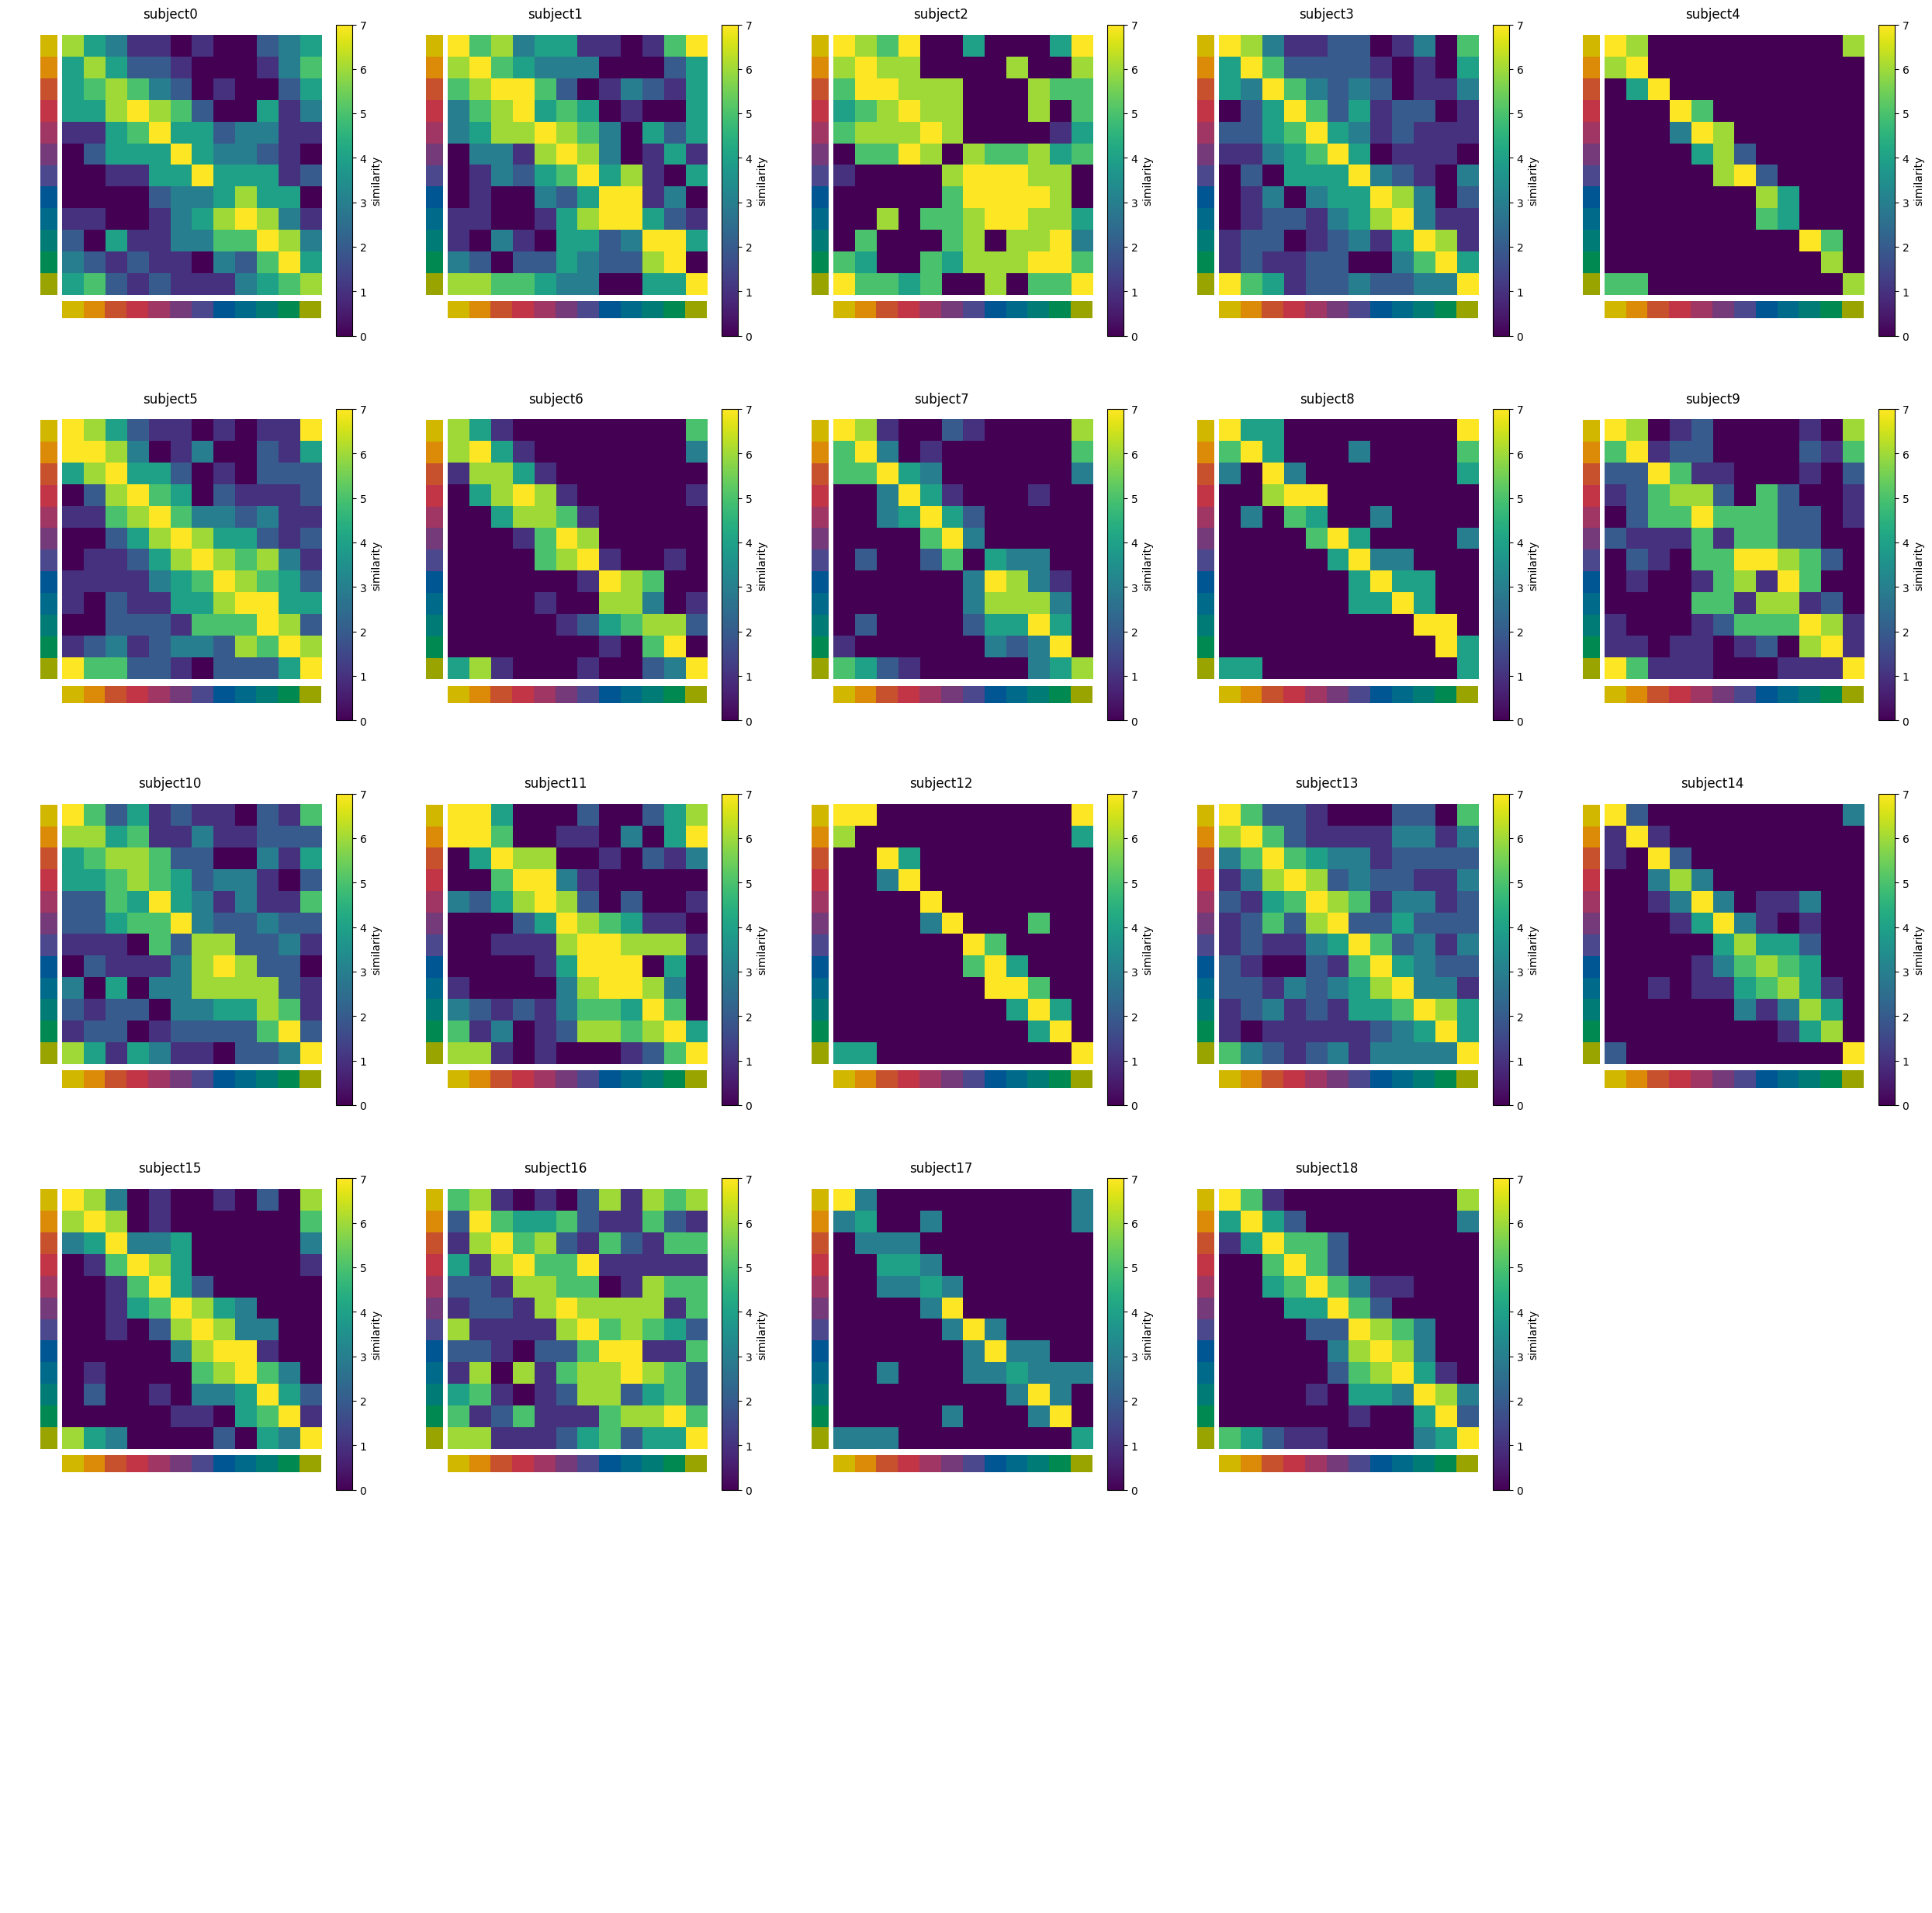

NameError: name 'subject' is not defined

In [ ]:
# Show matrices
show_heatmaps(0, 7, matrices=pMatrices, titles=["subject" + str(p) for p in pIds], cbar_label="similarity", color_labels=unique_colours)

for f in range(0, len(pFiles)):
    print("subject" + str(f) + ' ' + pFiles[f])


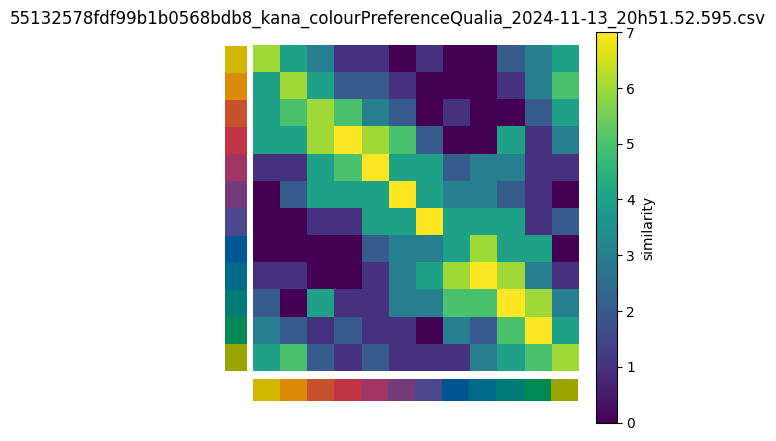

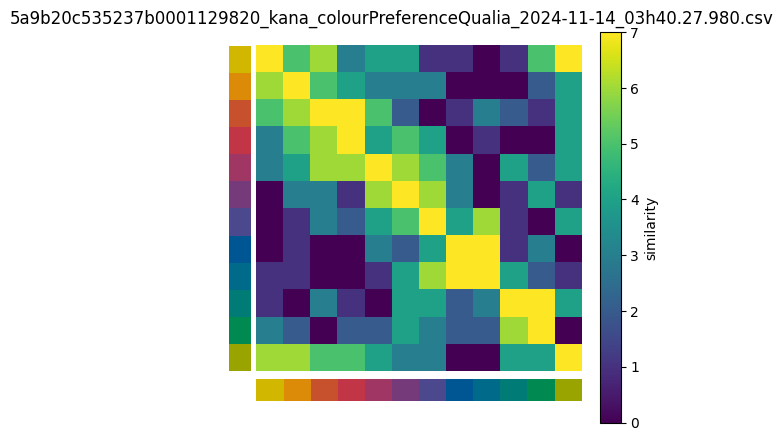

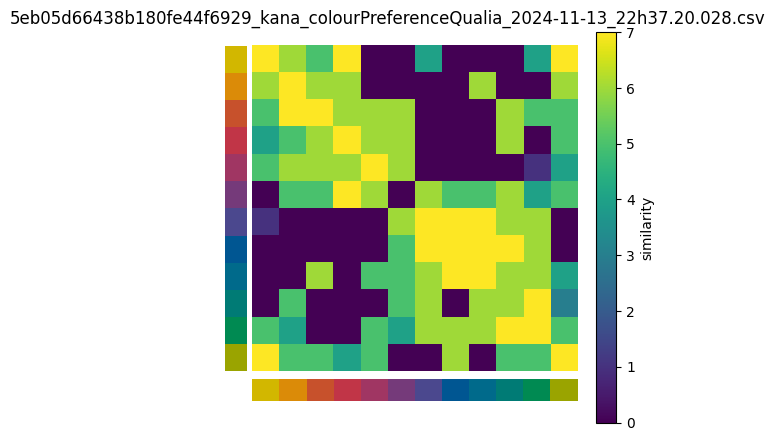

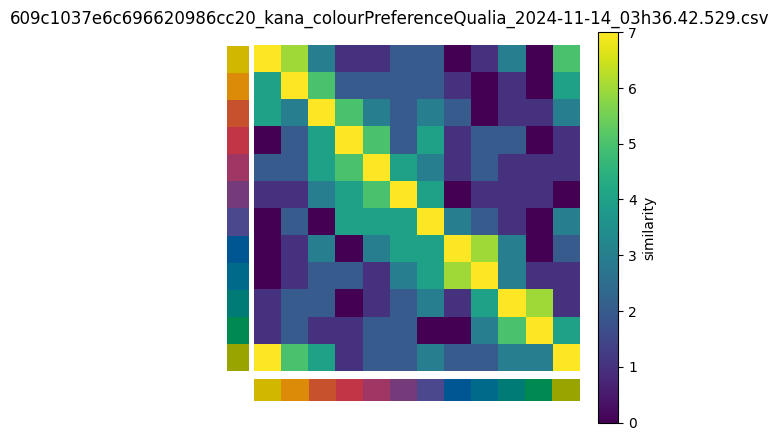

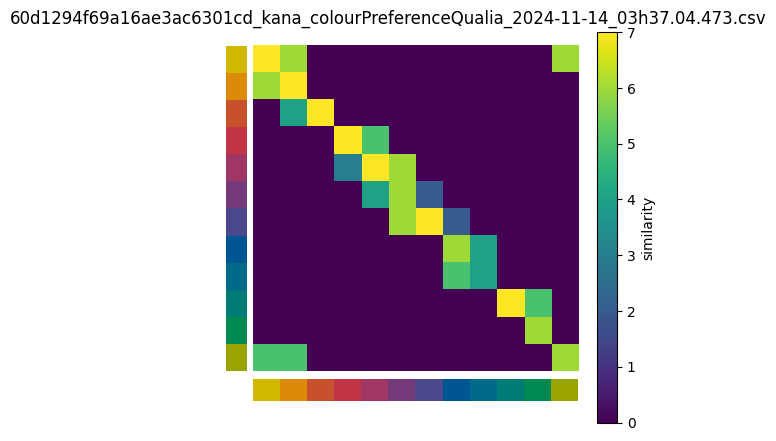

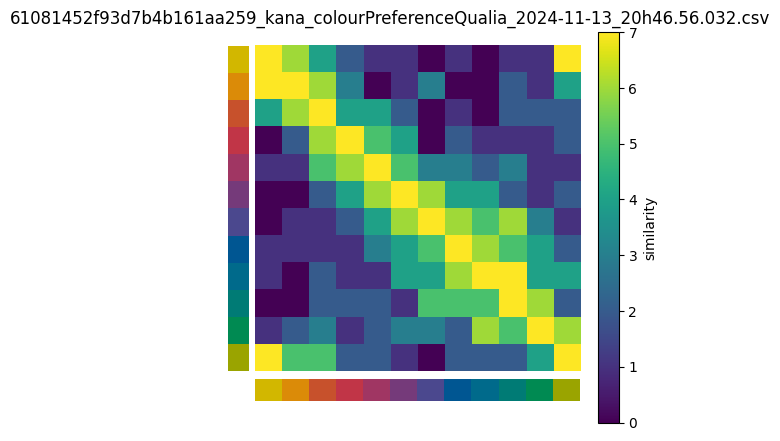

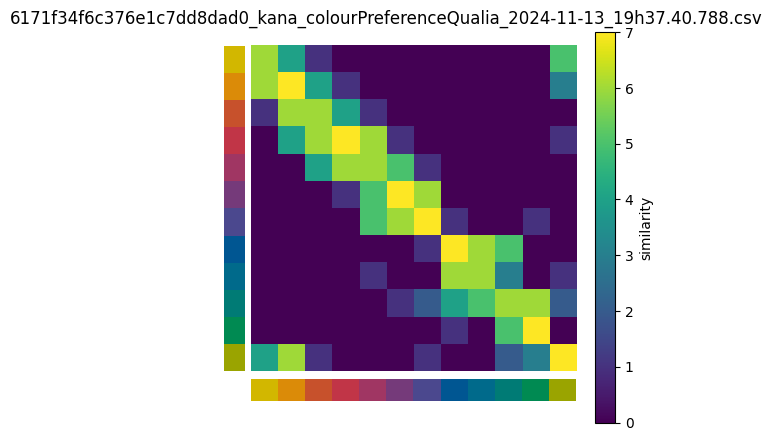

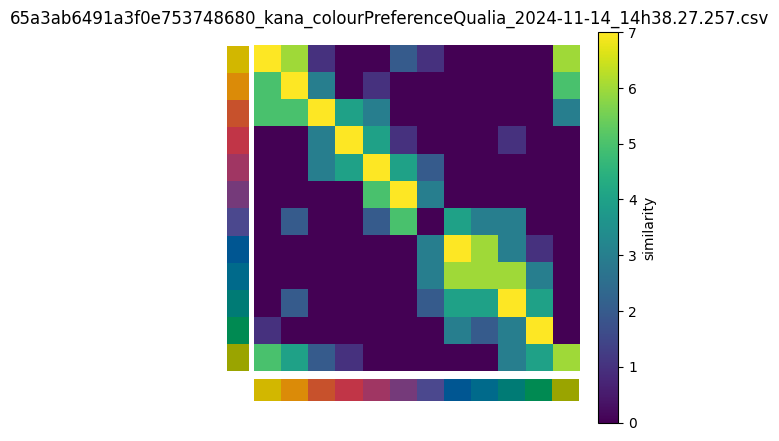

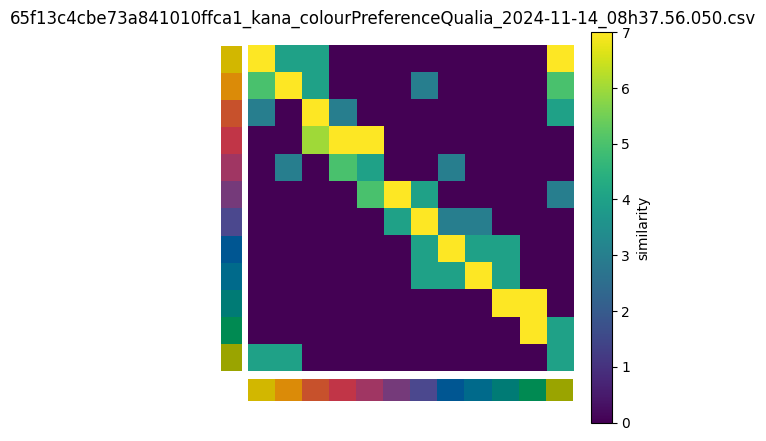

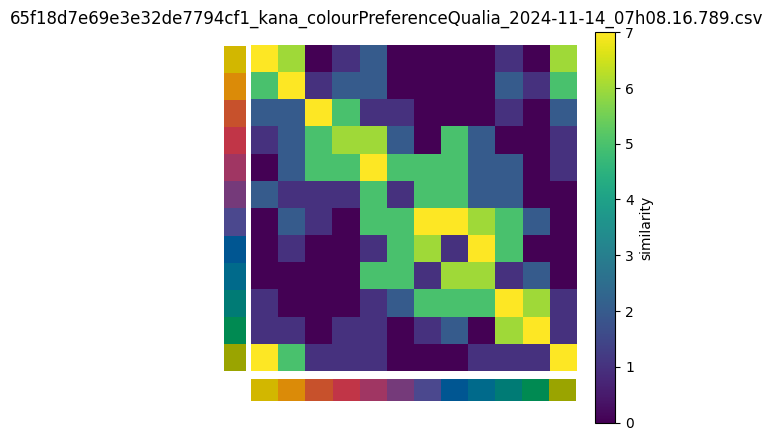

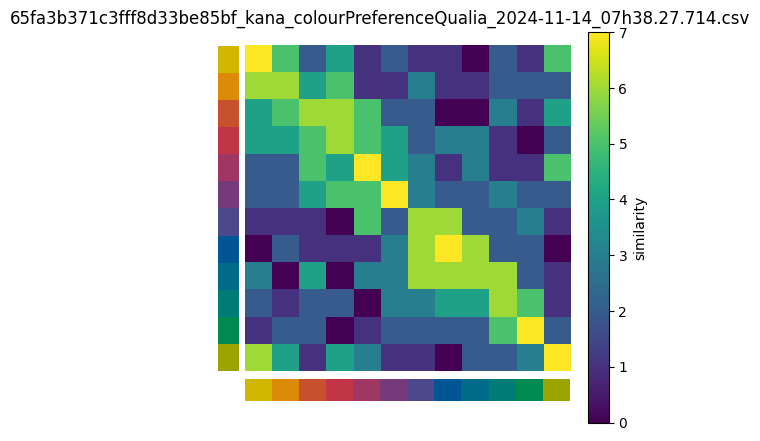

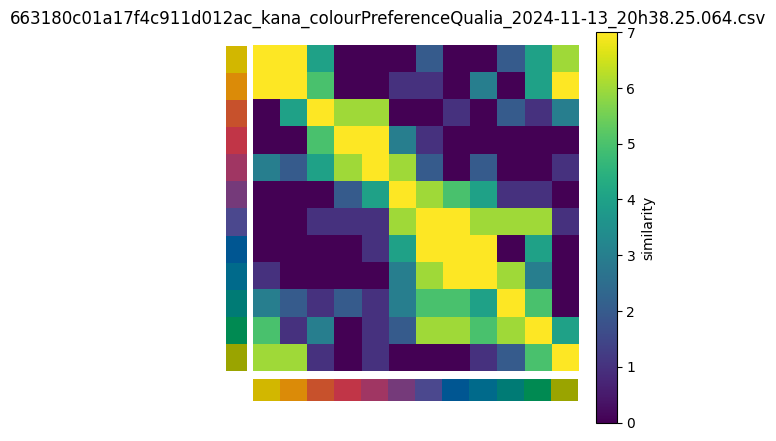

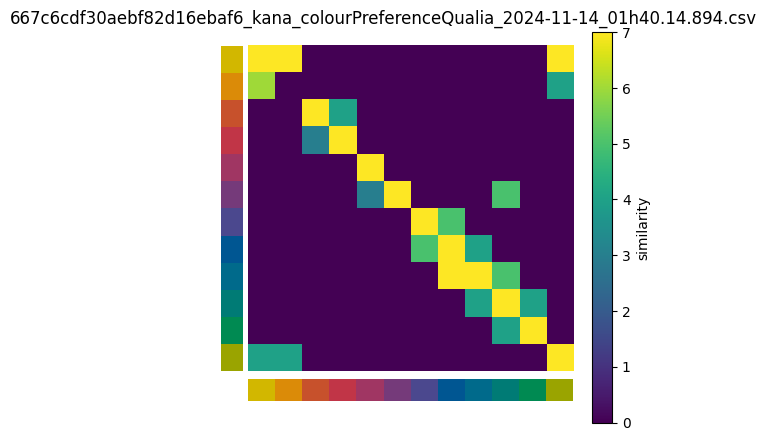

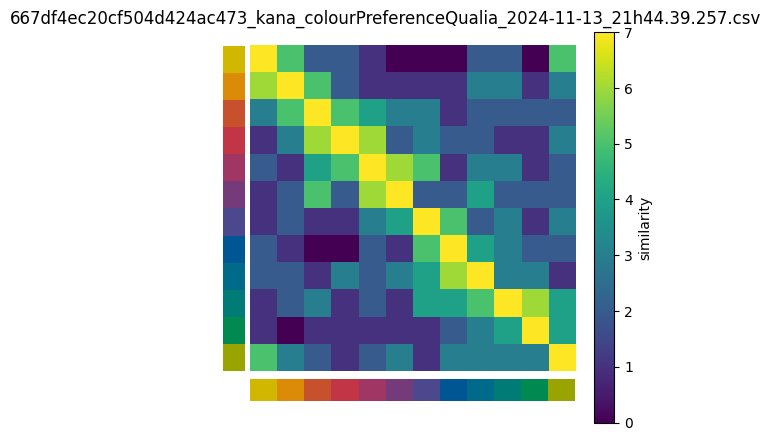

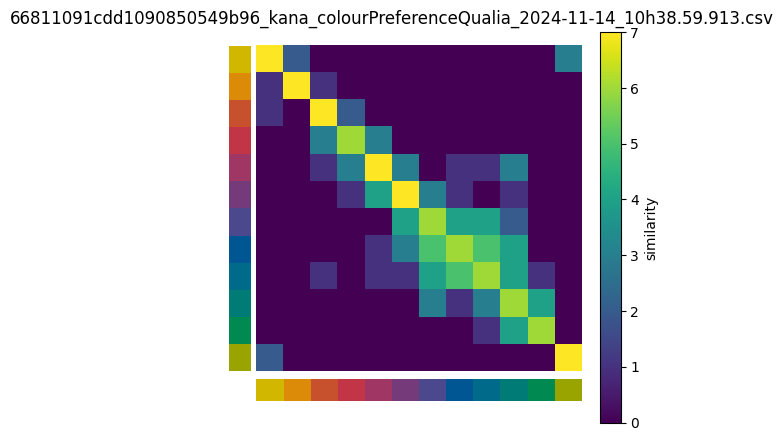

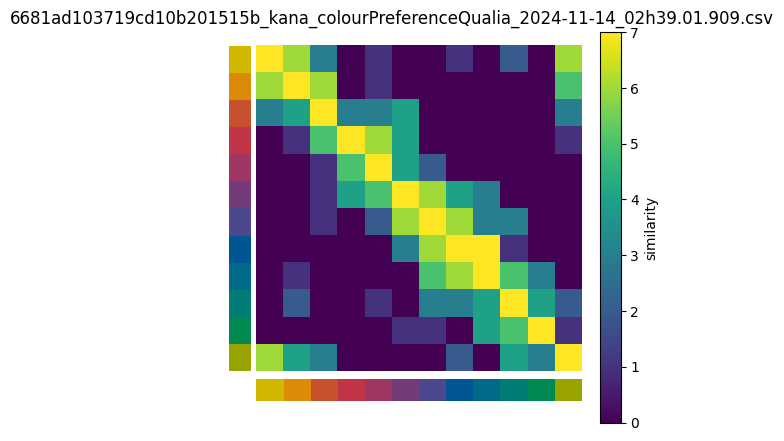

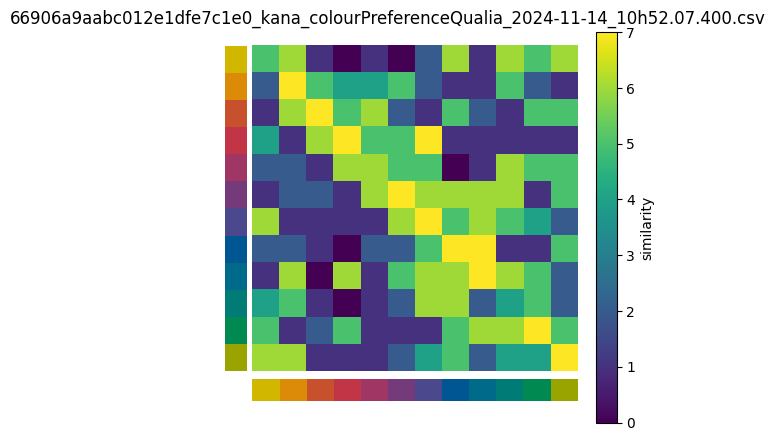

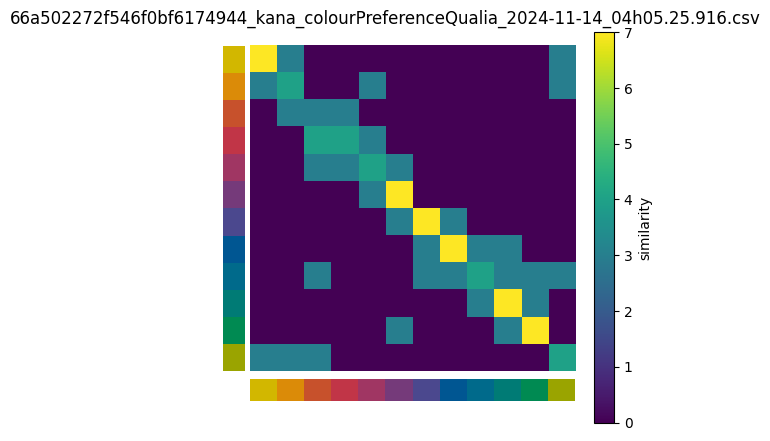

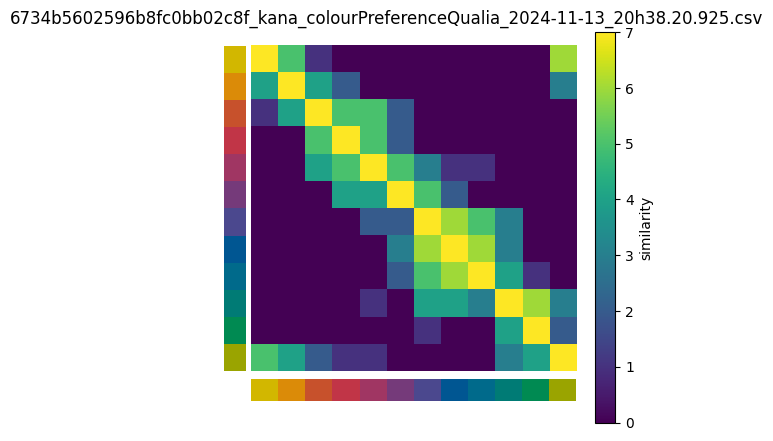

In [8]:
for filename in os.listdir('raw_data/kana_colourpreferencequalia-master/data'):
    if filename.endswith(".csv"):
        filepath = os.path.join('raw_data/kana_colourpreferencequalia-master/data', filename)
        
        # Load the CSV file
        df = pd.read_csv(filepath)

        # Filter for rows where 'response_type' is 'similarity'
        df_similarity = df[df['response_type'] == 'similarity']

        # Extract columns
        colour1 = df_similarity['colour1']
        colour2 = df_similarity['colour2']
        target_preference = df_similarity['response']

        # Create and fill the matrix
        matrix_size = len(colour_index)
        matrix = np.zeros((matrix_size, matrix_size))
        for c1, c2, tp in zip(colour1, colour2, target_preference):
            I = colour_index[c1]
            j = colour_index[c2]
            matrix[j, I] = tp

        # Plot the heatmap for this file
        show_heatmap(matrix, filename, cbar_label="similarity", color_labels=unique_colours)

In [42]:
folder_path = 'raw_data/kana_colourpreferencequalia-master/data'

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        
        df = pd.read_csv(filepath, usecols=['response_type', 'response', 'colour1', 'colour2', 'trials.thisIndex', 'practice_trial'])

        # Omit practice trials
        df = df[df['practice_trial'] != 1]  

        df_similarity = df[df['response_type'] == 'similarity']

        # Group by 'trials.thisIndex'
        grouped = df_similarity.groupby('trials.thisIndex')['response'].apply(list).reset_index()

        # Filter for pairs with exactly two trials
        repeated_pairs = grouped[grouped['response'].apply(len) == 2]

        # Check if there are any repeated pairs
        if len(repeated_pairs) > 0:
            # Flatten the responses for repeated pairs
            responses_trial1 = np.array(repeated_pairs['response'].apply(lambda x: x[0]).tolist())
            responses_trial2 = np.array(repeated_pairs['response'].apply(lambda x: x[1]).tolist())

            # Calculate overall correlation for repeated color pairs
            overall_correlation = pearsonr(responses_trial1, responses_trial2)[0]

            print(f"Overall Pearson Correlation for {filename}: {overall_correlation}")
        else:
            print(f"No repeated pairs found in {filename}")

Overall Pearson Correlation for 663180c01a17f4c911d012ac_kana_colourPreferenceQualia_2024-11-13_20h38.25.064.csv: 0.9539037978413332
Overall Pearson Correlation for 6734b5602596b8fc0bb02c8f_kana_colourPreferenceQualia_2024-11-13_20h38.20.925.csv: 0.923069782854075
Overall Pearson Correlation for 65fa3b371c3fff8d33be85bf_kana_colourPreferenceQualia_2024-11-14_07h38.27.714.csv: 0.7610153645142377
Overall Pearson Correlation for 66a502272f546f0bf6174944_kana_colourPreferenceQualia_2024-11-14_04h05.25.916.csv: 0.6335525936249407
Overall Pearson Correlation for 65f18d7e69e3e32de7794cf1_kana_colourPreferenceQualia_2024-11-14_07h08.16.789.csv: 0.7280800135701446
Overall Pearson Correlation for 65f13c4cbe73a841010ffca1_kana_colourPreferenceQualia_2024-11-14_08h37.56.050.csv: 0.5296629148861249
Overall Pearson Correlation for 60d1294f69a16ae3ac6301cd_kana_colourPreferenceQualia_2024-11-14_03h37.04.473.csv: 0.9402983133076948
Overall Pearson Correlation for 609c1037e6c696620986cc20_kana_colourPr

# Value Mapping to -3.5 ~ 3.5 - raw matrix

In [162]:
# Apply the transformation rule to the entire matrix
value_mapped_raw_1 = np.vectorize(transform_value)(matrix_1)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_raw_1, 0)

# Convert to DataFrame for better readability
value_mapped_raw_1_df = pd.DataFrame(value_mapped_raw_1, index=unique_colours, columns=unique_colours)

In [163]:
# Apply the transformation rule to the entire matrix
value_mapped_raw_2 = np.vectorize(transform_value)(matrix_2)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_raw_2, 0)

# Convert to DataFrame for better readability
value_mapped_raw_2_df = pd.DataFrame(value_mapped_raw_2, index=unique_colours, columns=unique_colours)

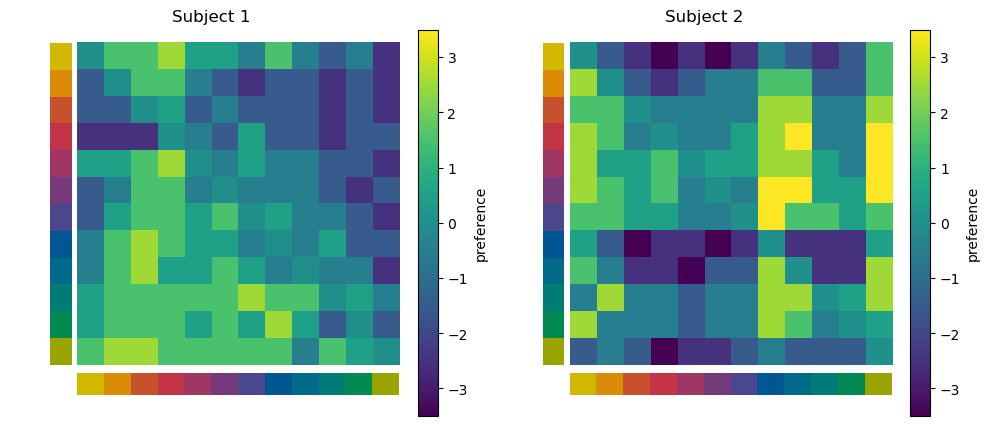

In [164]:
show_heatmaps(-3.5, 3.5, matrices=[value_mapped_raw_1, value_mapped_raw_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# Value Mapping - symmetric

In [165]:
# Get the size of the matrix (assume it's square)
n = matrix_1.shape[0]

# Create an empty matrix to store the symmetrical version
value_mapped_sym_1 = np.zeros_like(matrix_1)

# Loop through the upper triangle and the diagonal of the matrix
for i in range(n):
    for j in range(i, n):
        # Compute the average of the symmetric cells (i,j) and (j,i)
        avg_value = (abs(value_mapped_raw_1[i, j]) + abs(value_mapped_raw_1[j, i])) / 2.0
        # Assign the average to both (i,j) and (j,i) in the new symmetrical matrix
        value_mapped_sym_1[i, j] = avg_value
        value_mapped_sym_1[j, i] = avg_value

# Set all diagonal elements to zero
np.fill_diagonal(value_mapped_sym_1, 0)

# Convert to DataFrame for better readability
value_mapped_sym_1_df = pd.DataFrame(value_mapped_sym_1, index=unique_colours, columns=unique_colours)

In [166]:
# Get the size of the matrix (assume it's square)
n = matrix_2.shape[0]

# Create an empty matrix to store the symmetrical version
value_mapped_sym_2 = np.zeros_like(matrix_2)

# Loop through the upper triangle and the diagonal of the matrix
for i in range(n):
    for j in range(i, n):
        # Compute the average of the symmetric cells (i,j) and (j,i)
        avg_value = (abs(value_mapped_raw_2[i, j]) + abs(value_mapped_raw_2[j, i])) / 2.0
        # Assign the average to both (i,j) and (j,i) in the new symmetrical matrix
        value_mapped_sym_2[i, j] = avg_value
        value_mapped_sym_2[j, i] = avg_value

# Set all diagonal elements to zero
np.fill_diagonal(value_mapped_sym_2, 0)

# Convert to DataFrame for better readability
value_mapped_sym_1_df = pd.DataFrame(value_mapped_sym_2, index=unique_colours, columns=unique_colours)

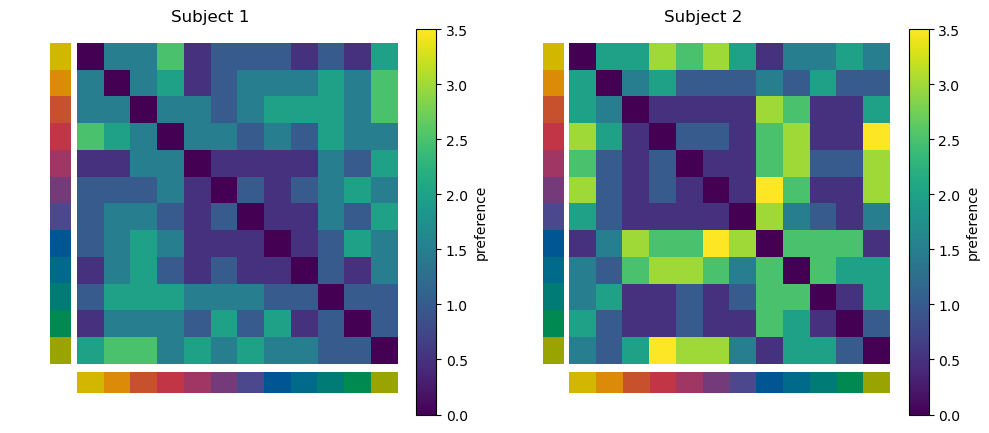

In [167]:
show_heatmaps( 0, 3.5, matrices=[value_mapped_sym_1, value_mapped_sym_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# MDS

### 1D MDS and overall preference rating

In [168]:
def plot_1DMDS_overallPreference(matrix_transformed_1, matrix_transformed_2, matrix_transformed_1_as, matrix_transformed_2_as, unique_colours):
    embeddings = []
    for RDM in [matrix_transformed_1, matrix_transformed_2]:
        mds = MDS(n_components=1, dissimilarity='precomputed', random_state=5)
        embedding = mds.fit_transform(RDM)
        embeddings.append(embedding)

    row_averages_1 = matrix_transformed_1_as.mean(axis=0).reshape(-1, 1)
    embeddings_1 = np.hstack((embeddings[0], row_averages_1))

    row_averages_2 = matrix_transformed_2_as.mean(axis=0).reshape(-1, 1)
    embeddings_2 = np.hstack((embeddings[1], row_averages_2))

    embeddings_3 = [embeddings_1, embeddings_2]

    # Plot the embeddings
    plt.figure(figsize=(12, 6))

    # Plot the first embedding
    plt.subplot(1, 2, 1)
    plt.scatter(embeddings_3[0][:, 0], embeddings_3[0][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings_3[0][i, 0], embeddings_3[0][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 1')
    plt.xlabel('MDS Dimension 1', fontsize=14)
    plt.ylabel('Overall Preference value', fontsize=14)

    # Plot the second embedding
    plt.subplot(1, 2, 2)
    plt.scatter(embeddings_3[1][:, 0], embeddings_3[1][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings_3[1][i, 0], embeddings_3[1][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 2')
    plt.xlabel('MDS Dimension 1', fontsize=14)
    plt.ylabel('Overall Preference value', fontsize=14)

    plt.tight_layout()
    plt.show()

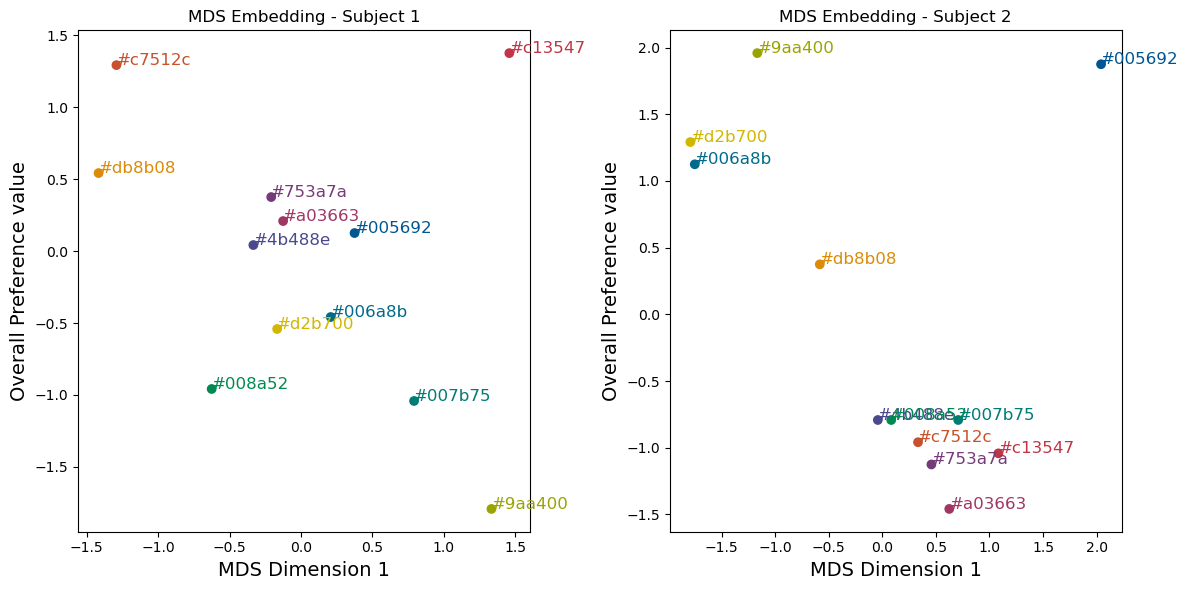

In [169]:
plot_1DMDS_overallPreference(value_mapped_sym_1, value_mapped_sym_2, value_mapped_raw_1, value_mapped_raw_2, unique_colours)

### 3D MDS

In [170]:
def plot_3D_embeddings(embeddings, titles, color_labels, overlay=False):

    if overlay:
        fig = go.Figure()
        for i, embedding in enumerate(embeddings):
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center",
                name=titles[i]
            ))
        fig.update_layout(
            title='Overlayed MDS Embeddings',
            scene=dict(
                xaxis_title='Dimension 1',
                yaxis_title='Dimension 2',
                zaxis_title='Dimension 3'
            ),
            height=800,
            plot_bgcolor='white'
        )
        fig.show()
    else:
        for i, embedding in enumerate(embeddings):
            fig = go.Figure()
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center"
            ))
            fig.update_layout(
                title=f'MDS Embedding - {titles[i]}',
                scene=dict(
                    xaxis_title='Dimension 1',
                    yaxis_title='Dimension 2',
                    zaxis_title='Dimension 3'
                ),
                height=800,
                plot_bgcolor='white'
            )
            fig.show()


def plot_3DMDS(matrix_transformed_1, matrix_transformed_2, titles, color_labels, overlay=False):
    # Compute MDS for each transformed matrix
    embeddings = []
    for RDM in [matrix_transformed_1, matrix_transformed_2]:
        mds = MDS(n_components=3, dissimilarity='precomputed', random_state=5)
        embedding = mds.fit_transform(RDM)
        embeddings.append(embedding)

    plot_3D_embeddings(embeddings, titles, color_labels, overlay=False)

In [171]:
# Plot the embeddings
plot_3DMDS(value_mapped_sym_1, value_mapped_sym_2, titles=['Subject 1', 'Subject 2'], color_labels=unique_colours, overlay=False)

### 2D MDS

In [172]:
def plot_2DMDS(matrix_transformed_1, matrix_transformed_2):
    # List to store the embeddings
    embeddings = []

    # Compute MDS for each transformed matrix
    for RDM in [matrix_transformed_1, matrix_transformed_2]:
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
        embedding = mds.fit_transform(RDM)
        embeddings.append(embedding)

    # Define unique colors
    unique_colours = np.array(["#d2b700", "#db8b08", "#c7512c", "#c13547", "#a03663", "#753a7a", "#4b488e", "#005692", "#006a8b", "#007b75", "#008a52", "#9aa400"])

    # Plot the embeddings
    plt.figure(figsize=(12, 6))

    # Plot the first embedding
    plt.subplot(1, 2, 1)
    plt.scatter(embeddings[0][:, 0], embeddings[0][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings[0][i, 0], embeddings[0][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 1')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Plot the second embedding
    plt.subplot(1, 2, 2)
    plt.scatter(embeddings[1][:, 0], embeddings[1][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings[1][i, 0], embeddings[1][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 2')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    plt.tight_layout()
    plt.show()

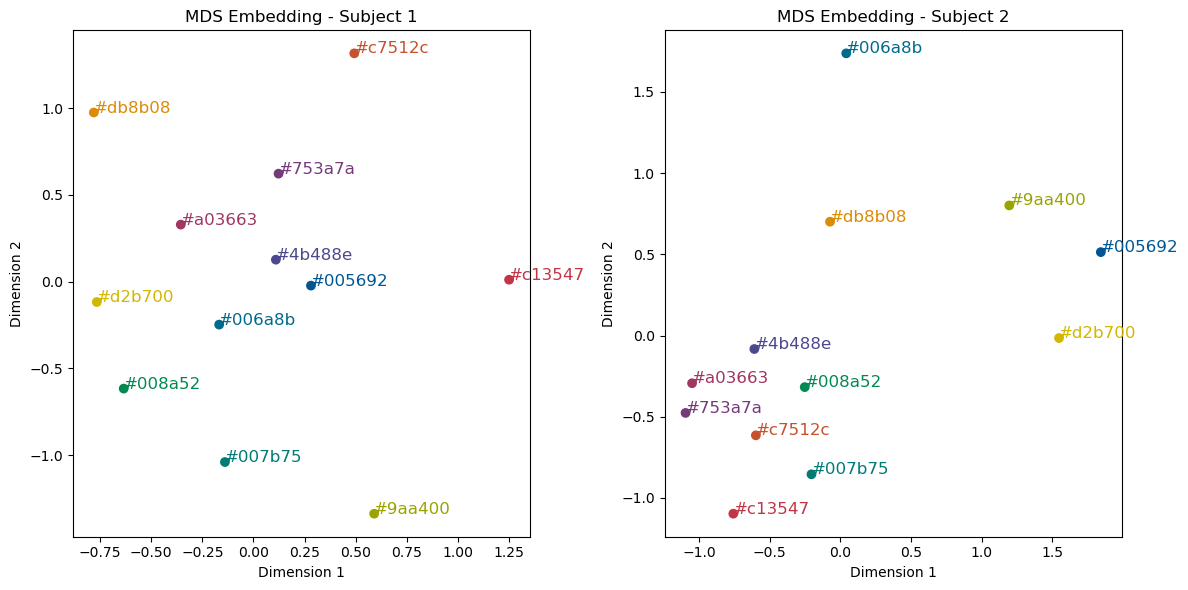

In [173]:
plot_2DMDS(value_mapped_sym_1, value_mapped_sym_2)

### 3D MDS with preference as the z-axis

In [174]:
def plot_3DMDS_overallPreference(matrix_transformed_1, matrix_transformed_2, matrix_transformed_1_as, matrix_transformed_2_as, unique_colours):
    # List to store the embeddings
    embeddings = []

    # First matrix
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
    embedding_2d = mds.fit_transform(matrix_transformed_1)

    # Calculate the average value for each column
    row_averages_1 = matrix_transformed_1_as.mean(axis=0).reshape(-1, 1)

    # Add the row averages as the third dimension
    embedding_3d = np.hstack((embedding_2d, row_averages_1))
    embeddings.append(embedding_3d)

    # Second matrix
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
    embedding_2d = mds.fit_transform(matrix_transformed_2)

    # Calculate the average value for each row
    row_averages_2 = matrix_transformed_2_as.mean(axis=0).reshape(-1, 1)

    # Add the row averages as the third dimension
    embedding_3d = np.hstack((embedding_2d, row_averages_2))
    embeddings.append(embedding_3d)

    plot_3D_embeddings(embeddings, titles=['Subject 1', 'Subject 2'], color_labels=unique_colours, overlay=False)

In [175]:
plot_3DMDS_overallPreference(value_mapped_sym_1, value_mapped_sym_2, value_mapped_raw_1, value_mapped_raw_2, unique_colours)

# GWOT

### GWOT with symmetric matrix (preference distance)

RSA correlation coefficient :  -0.06009121106769349


/opt/anaconda3/envs/colorpreferencequalia/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



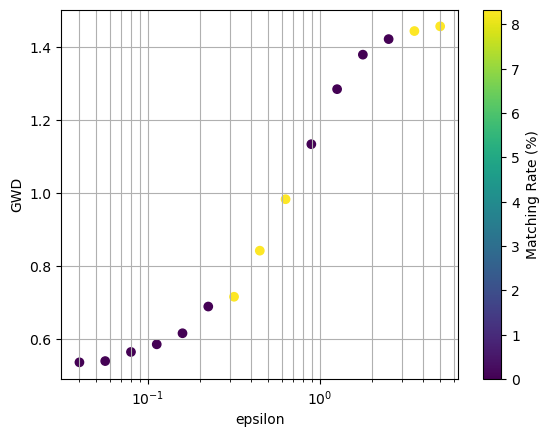

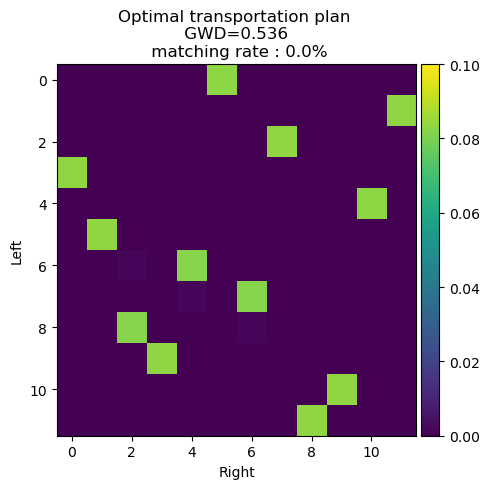

In [176]:
RSA_corr = RSA(value_mapped_sym_1, value_mapped_sym_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_sym, gwds_sym, matching_rates_sym = GWD_and_plot(value_mapped_sym_1, value_mapped_sym_2, epsilons)

In [177]:
embeddings = []
for RDM in [value_mapped_sym_1, value_mapped_sym_2]:
    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=5)
    embedding = mds.fit_transform(RDM)
    embeddings.append(embedding)

embeddings_y = embeddings[1]
# barycentric projection of embedding2 to the space of embedding1
projected_embeddings_x = OT_plan_sym @ embeddings_y * len(OT_plan_sym)

plot_3D_embeddings(
    embeddings=[embeddings_y, projected_embeddings_x],
    titles=['Subject 1', 'Subject 2'],
    overlay=False,
    color_labels=unique_colours)

In [178]:
projected_embeddings_x

array([[ 0.16422514, -0.49382098, -1.0530456 ],
       [ 0.4535742 ,  0.33911254,  1.36249675],
       [ 0.05793994,  1.03307087,  1.59465017],
       [-0.66504968,  0.75599356,  1.18094877],
       [-0.01716727, -0.04517304, -0.39558258],
       [ 0.42630791, -0.43266724,  0.44557358],
       [ 0.56299409, -0.08997941, -0.9612667 ],
       [ 0.13451509, -0.38325121, -0.50260155],
       [ 0.03819068, -0.02250521, -0.84864017],
       [-0.2037779 ,  0.14904579, -1.29540517],
       [-0.34822306,  0.27245259, -0.7287655 ],
       [-0.60371419, -1.08223224,  1.201787  ]])

### GWOT with asymmetric matrix (preference ratings)

RSA correlation coefficient :  -0.3970177769528424


/opt/anaconda3/envs/colorpreferencequalia/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



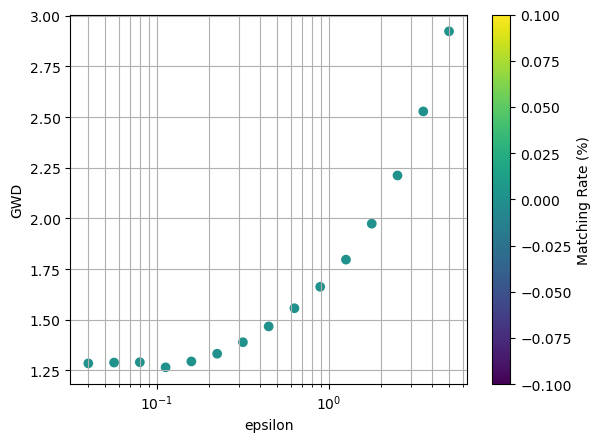

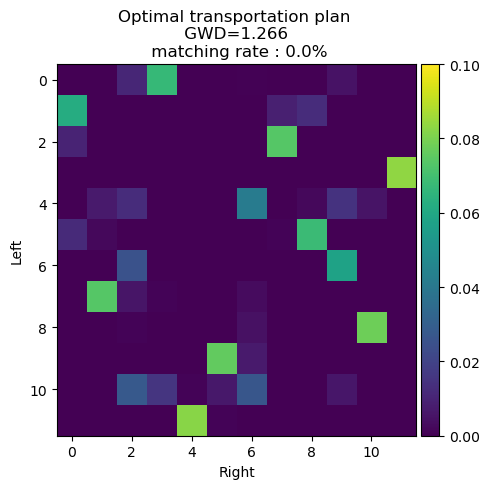

In [179]:
RSA_corr = RSA(value_mapped_raw_1, value_mapped_raw_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_as, gwds_as, matching_rates_as = GWD_and_plot(value_mapped_raw_1, value_mapped_raw_2, epsilons)

### GWOT with random matrix - triangular based

#### Kana

In [180]:
value_mapped_as_shuffledByDiagonal_1 = shuffle_upper_and_lower_triangular(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  -0.18606870229007647


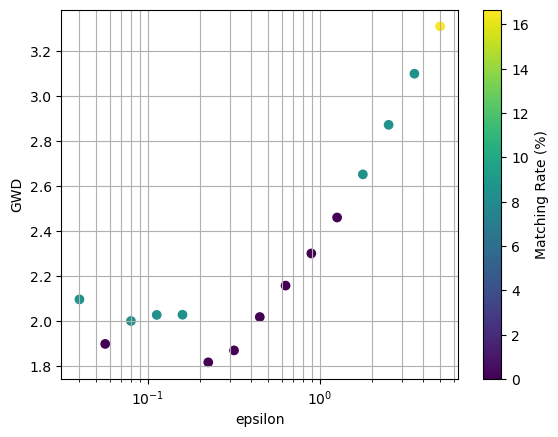

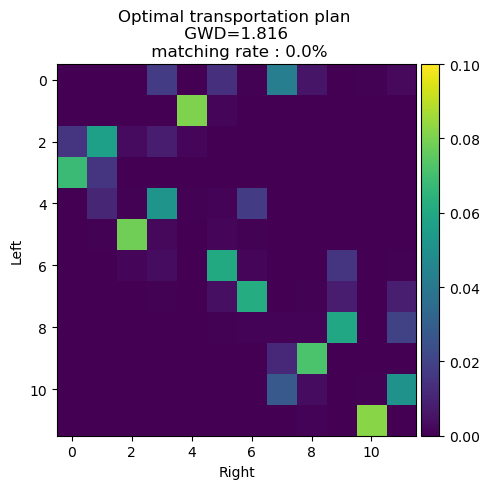

In [181]:
RSA_corr = RSA(value_mapped_raw_1, value_mapped_as_shuffledByDiagonal_1)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledDiagonal_1, gwds_withShuffledDiagonal_1, matching_rates_withShuffledDiagonal_1 = GWD_and_plot(value_mapped_raw_1, value_mapped_as_shuffledByDiagonal_1, epsilons)

#### Angus

In [182]:
value_mapped_as_shuffledByDiagonal_2 = shuffle_upper_and_lower_triangular(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  -0.0734218686011817


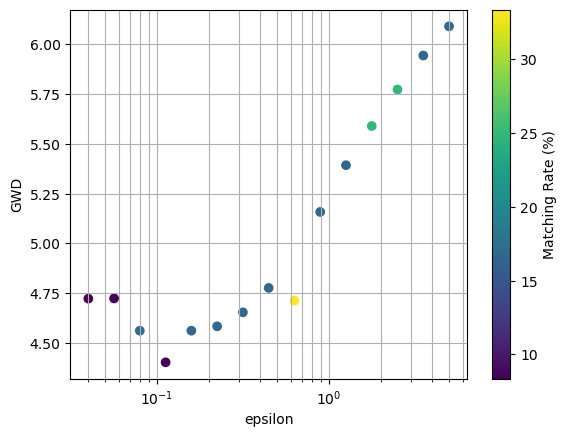

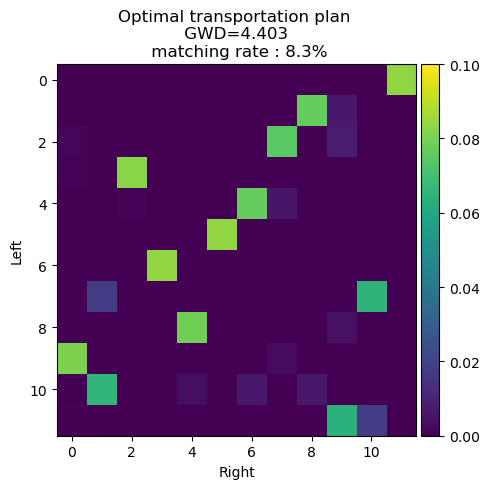

In [183]:
RSA_corr = RSA(value_mapped_raw_2, value_mapped_as_shuffledByDiagonal_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledDiagonal_2, gwds_withShuffledDiagonal_2, matching_rates_withShuffledDiagonal_2 = GWD_and_plot(value_mapped_raw_2, value_mapped_as_shuffledByDiagonal_2, epsilons)

### GWOT with random matrix - column based

#### Kana

In [184]:
value_mapped_as_shuffledByColumn_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.4931703344029102


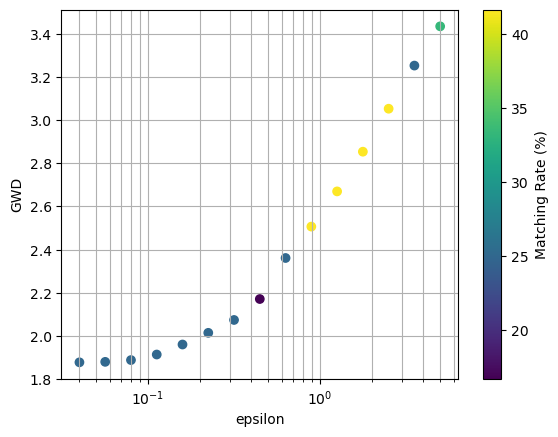

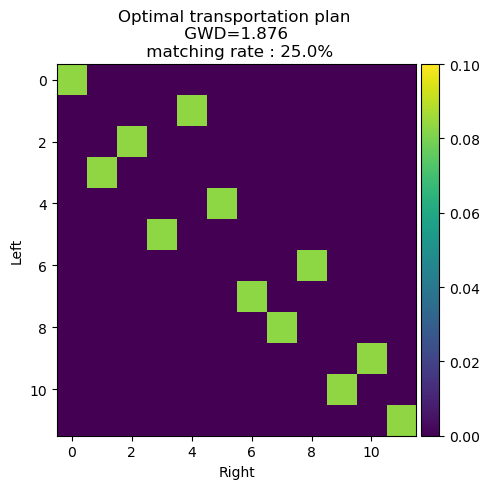

In [185]:
RSA_corr = RSA(value_mapped_raw_1, value_mapped_as_shuffledByColumn_1)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledColumn_1, gwds_withShuffledColumn_1, matching_rates_withShuffledColumn_1 = GWD_and_plot(value_mapped_raw_1, value_mapped_as_shuffledByColumn_1, epsilons)

#### Angus

In [186]:
value_mapped_as_shuffledByColumn_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.4461093554892964


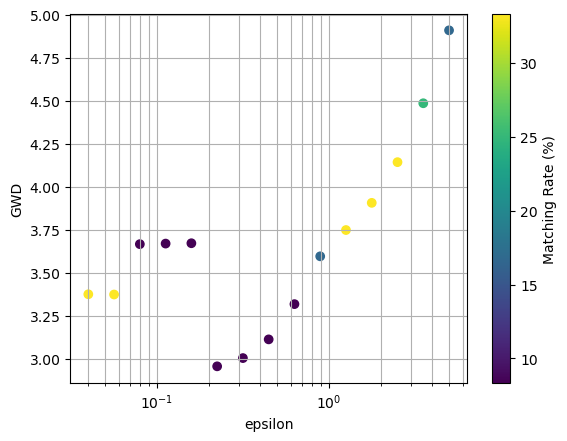

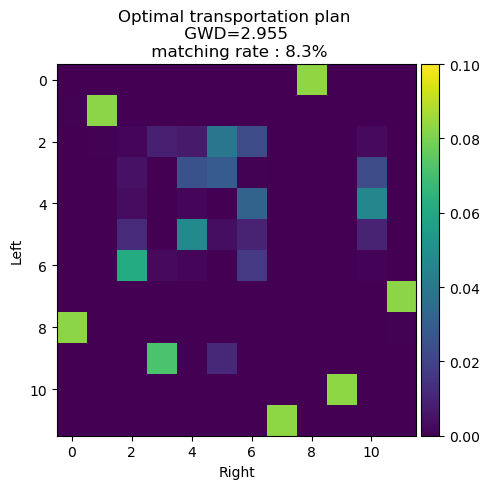

In [187]:
RSA_corr = RSA(value_mapped_raw_2, value_mapped_as_shuffledByColumn_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledColumn_2, gwds_withShuffledColumn_2, matching_rates_withShuffledColumn_2 = GWD_and_plot(value_mapped_raw_2, value_mapped_as_shuffledByColumn_2, epsilons)

### GWOT with random matrix - row based

#### Subject 1

In [188]:
value_mapped_as_shuffledByRow_1 = shuffle_row_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.10383897093031508


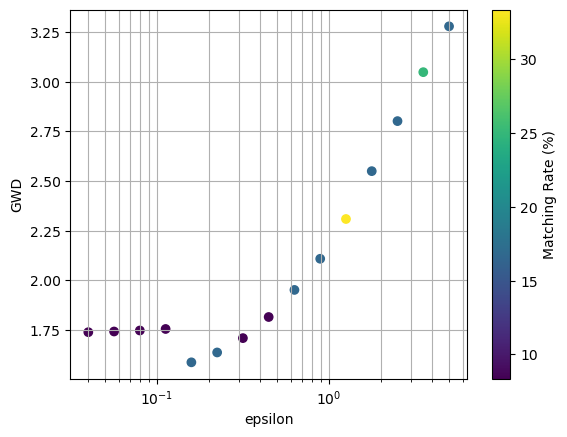

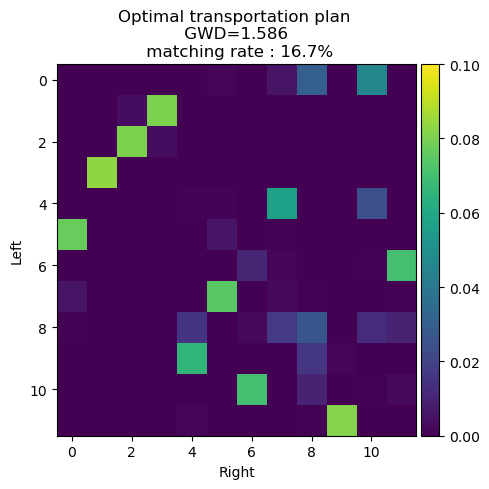

In [189]:
RSA_corr = RSA(value_mapped_raw_1, value_mapped_as_shuffledByRow_1)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledColumn_1, gwds_withShuffledRow_1, matching_rates_withShuffledRow_1 = GWD_and_plot(value_mapped_raw_1, value_mapped_as_shuffledByRow_1, epsilons)

#### Subject 2

In [190]:
value_mapped_as_shuffledByRow_2 = shuffle_row_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.3176007691021943


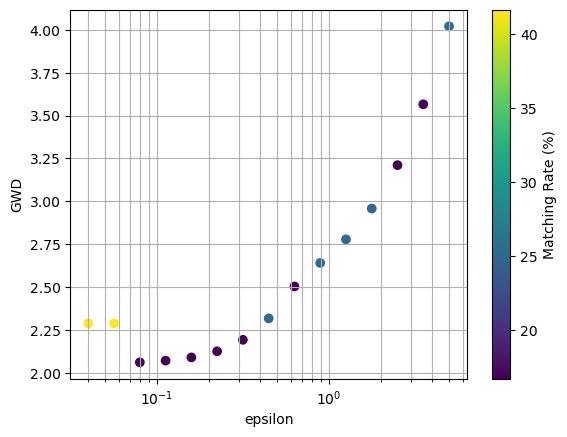

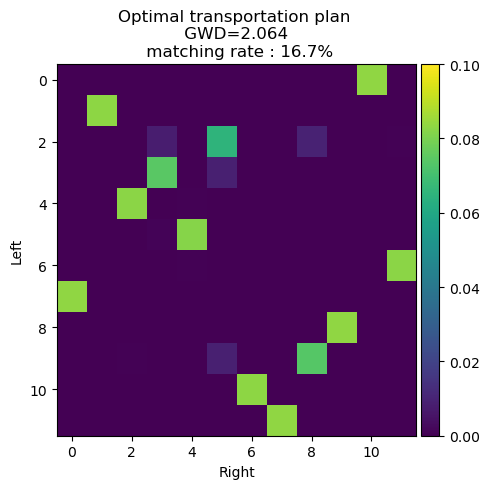

In [191]:
RSA_corr = RSA(value_mapped_raw_2, value_mapped_as_shuffledByRow_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledColumn_2, gwds_withShuffledRow_2, matching_rates_withShuffledRow_2 = GWD_and_plot(value_mapped_raw_2, value_mapped_as_shuffledByRow_2, epsilons)

### GWOT with random matrix - shuffled and shuffled (diagonal based)

#### Kana

In [192]:
value_mapped_as_shuffledByDiagonal_1_1 = shuffle_upper_and_lower_triangular(value_mapped_raw_1, matrix_size)
value_mapped_as_shuffledByDiagonal_1_2 = shuffle_upper_and_lower_triangular(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  -0.15458015267175595


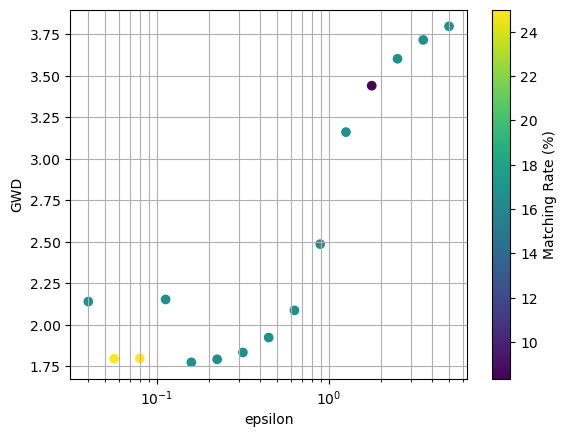

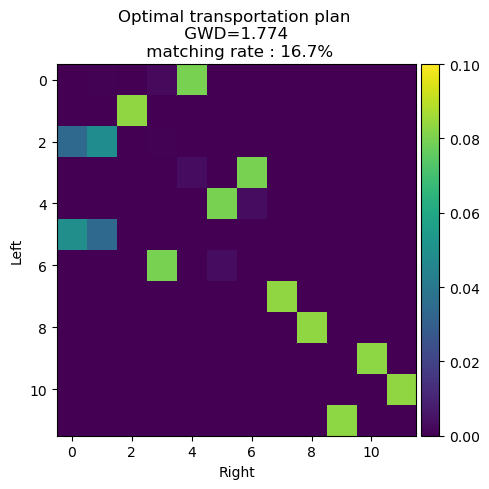

In [193]:
RSA_corr = RSA(value_mapped_as_shuffledByDiagonal_1_1, value_mapped_as_shuffledByDiagonal_1_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledDiagonal_1, gwds_ShuffledwithShuffledDiagonal_1, matching_rates_ShuffledwithShuffledDiagonal_1 = GWD_and_plot(value_mapped_as_shuffledByDiagonal_1_1, value_mapped_as_shuffledByDiagonal_1_2, epsilons)

#### Angus

In [194]:
value_mapped_as_shuffledByDiagonal_2_1 = shuffle_upper_and_lower_triangular(value_mapped_raw_2, matrix_size)
value_mapped_as_shuffledByDiagonal_2_2 = shuffle_upper_and_lower_triangular(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  -0.02322588193997544


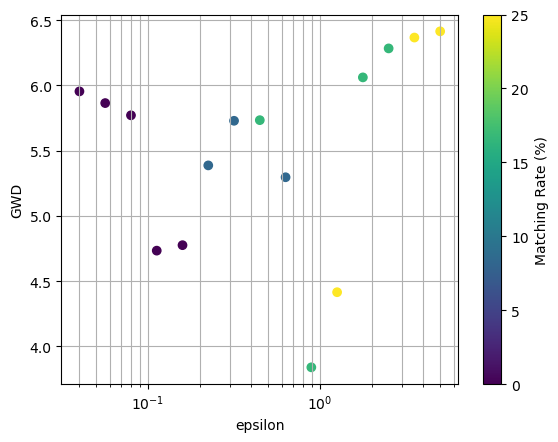

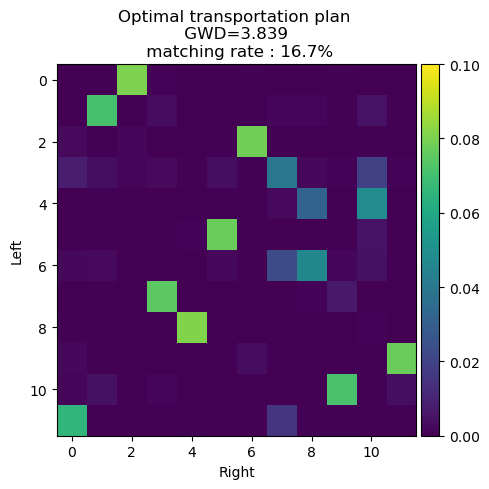

In [195]:
RSA_corr = RSA(value_mapped_as_shuffledByDiagonal_2_1, value_mapped_as_shuffledByDiagonal_2_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledDiagonal_2, gwds_ShuffledwithShuffledDiagonal_2, matching_rates_ShuffledwithShuffledDiagonal_2 = GWD_and_plot(value_mapped_as_shuffledByDiagonal_2_1, value_mapped_as_shuffledByDiagonal_2_2, epsilons)

### GWOT with random matrix - shuffled and shuffled (column based)

#### Kana

In [196]:
value_mapped_as_shuffledByColumn_1_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)
value_mapped_as_shuffledByColumn_1_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.4238179775106491


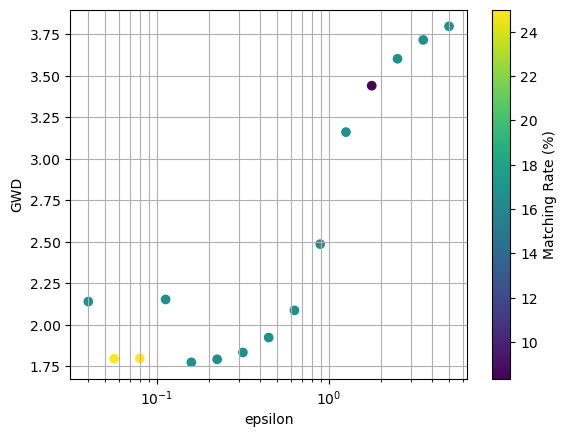

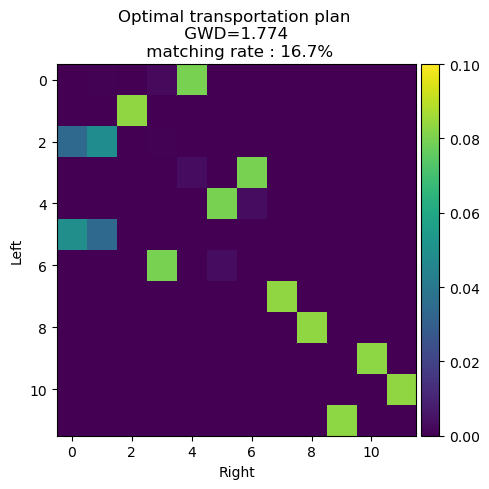

In [197]:
RSA_corr = RSA(value_mapped_as_shuffledByColumn_1_1, value_mapped_as_shuffledByColumn_1_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledColumn_1, gwds_ShuffledwithShuffledColumn_1, matching_rates_ShuffledwithShuffledColumn_1 = GWD_and_plot(value_mapped_as_shuffledByDiagonal_1_1, value_mapped_as_shuffledByDiagonal_1_2, epsilons)

#### Angus

In [198]:
value_mapped_as_shuffledByColumn_2_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)
value_mapped_as_shuffledByColumn_2_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.4724347920754641


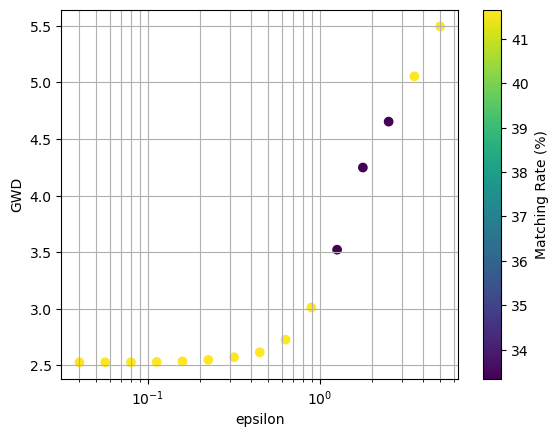

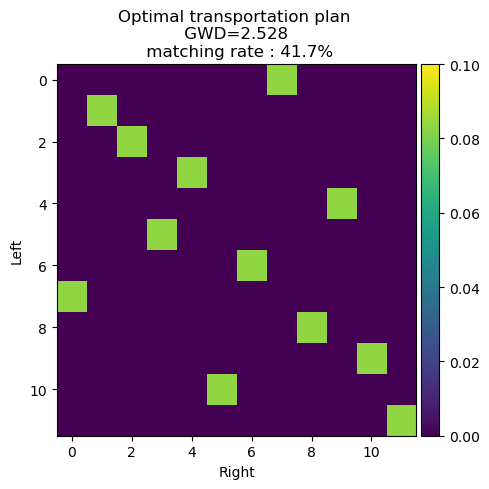

In [199]:
RSA_corr = RSA(value_mapped_as_shuffledByColumn_2_1, value_mapped_as_shuffledByColumn_2_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledColumn_2, gwds_ShuffledwithShuffledColumn_2, matching_rates_ShuffledwithShuffledColumn_2 = GWD_and_plot(value_mapped_as_shuffledByColumn_2_1, value_mapped_as_shuffledByColumn_2_2, epsilons)

### GWOT with random matrix - shuffled and shuffled (row based)

#### Subject 1

In [200]:
value_mapped_as_shuffledByRow_1_1 = shuffle_row_and_asymmetritisize(value_mapped_raw_1, matrix_size)
value_mapped_as_shuffledByRow_1_2 = shuffle_row_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.3842147764113706


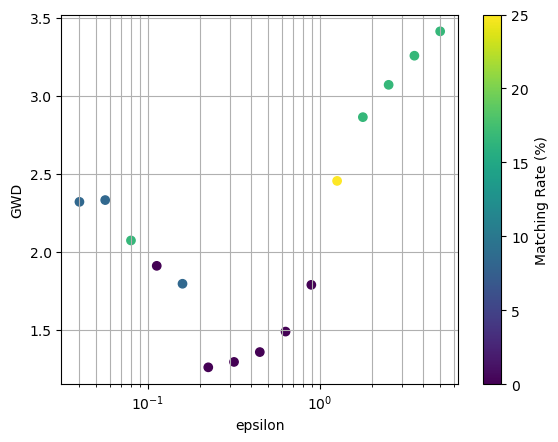

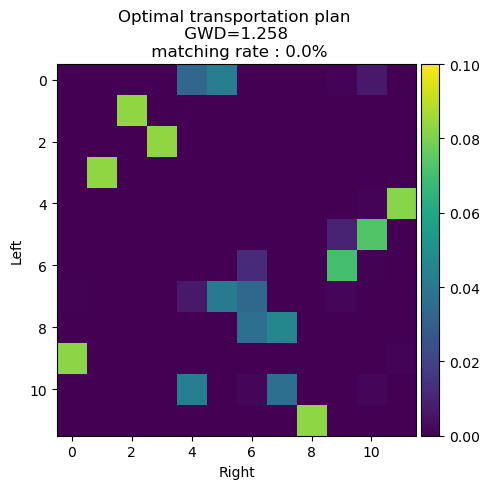

In [201]:
RSA_corr = RSA(value_mapped_as_shuffledByRow_1_1, value_mapped_as_shuffledByRow_1_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledRow_1, gwds_ShuffledwithShuffledRow_1, matching_rates_ShuffledwithShuffledRow_1 = GWD_and_plot(value_mapped_as_shuffledByRow_1_1, value_mapped_as_shuffledByRow_1_2, epsilons)

#### Subject 2

In [202]:
value_mapped_as_shuffledByRow_2_1 = shuffle_row_and_asymmetritisize(value_mapped_raw_2, matrix_size)
value_mapped_as_shuffledByRow_2_2 = shuffle_row_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.479712409789986


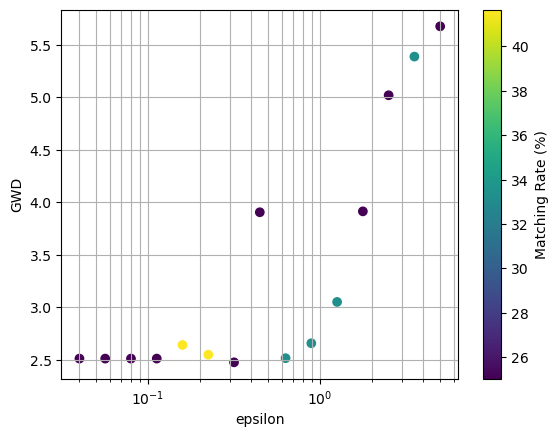

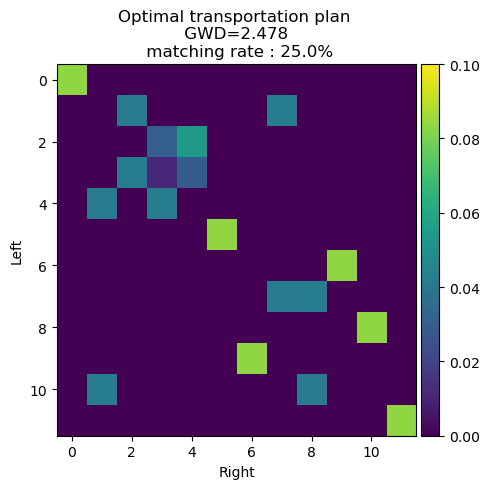

In [203]:
RSA_corr = RSA(value_mapped_as_shuffledByRow_2_1, value_mapped_as_shuffledByRow_2_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledRow_2, gwds_ShuffledwithShuffledRow_2, matching_rates_ShuffledwithShuffledRow_2 = GWD_and_plot(value_mapped_as_shuffledByRow_2_1, value_mapped_as_shuffledByRow_2_2, epsilons)